# Gaussian Process regression for fitting interatomic potentials
# Part 1
## Objectives
* Data representation using invariant descriptors
* Building covariance matrices for derived quantities - learning from total energy data
* Uncertainty analysis of predicted energy values
* Optimising hyperparameters
* Relaxing geometry using a machine learned potential



In [1]:
#!alias gcc='gcc-11'
#!alias cc='gcc-11'
#!alias g++='g++-11'
#!alias c++='c++-11'

In [4]:
#pip install GPy

In [5]:
#pip install ase

In [6]:
#pip install nglview

In [4]:
import numpy as np
import pandas as pd
import GPy

from ase.io import read
import nglview

from IPython.display import display

#%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from google.colab import output
#output.enable_custom_widget_manager()

In [5]:
custom_style_gold = {
    'axes.labelcolor': 'blue',
    'axes.edgecolor': 'gray',
    'axes.facecolor': '#FFFFF0',
    'xtick.color': 'green',
    'ytick.color': 'red',
    'font.size': 15,
    'legend.fontsize': 12,
    'grid.color': '#E6DAA6',
}


In [6]:
plt.rcParams['figure.figsize'] = [10, 8]

## The first simple step
### Learning the interaction energy of a single water molecule

The quantum mechanical energy of a water molecule - within the Born-Oppenheimer approximation - is a function of the geometry of the molecule, i.e. the Cartesian coordinates ${r}_{O}$, ${r}_{H_1}$ and  ${r}_{H_2}$. Of course, this energy does not depend on the orientation of the water molecule if there is no external field interacting with the molecule.


We can rewrite the energy function as $E(\mathbf{r}_{\rm O},\mathbf{r}_{\rm H_1},\mathbf{r}_{\rm H_2}) \equiv E(r_{\rm OH_1},r_{\rm OH_2},\theta_{\rm HOH})$ where $r_{\rm OH}$ are the bond lengths and $\theta_{\rm HOH}$ the bond angle. This description is invariant to rotations and translations. We also know that the 'label' of the hydrogens is unimportant (i.e. swapping $\rm H_1$ and $\rm H_2$ does not change the energy), therefore it is useful to symmetrise the distances.

In this project, I use the following data coordinates:
* $r_+ = r_{\rm OH_1} + r_{\rm OH_2}$
* $r_- = (r_{\rm OH_1} - r_{\rm OH_2})^2$
* $a = \mathbf{r}_{\rm OH_1} \cdot \mathbf{r}_{\rm OH_2}$







In [7]:
water_configs = read("water_configs.xyz", format="extxyz", index=":")
# There should be 2886 independent water molecules
print(len(water_configs))

2886


In [15]:
# optional - for visualisation
#nglview.show_asetraj(water_configs)

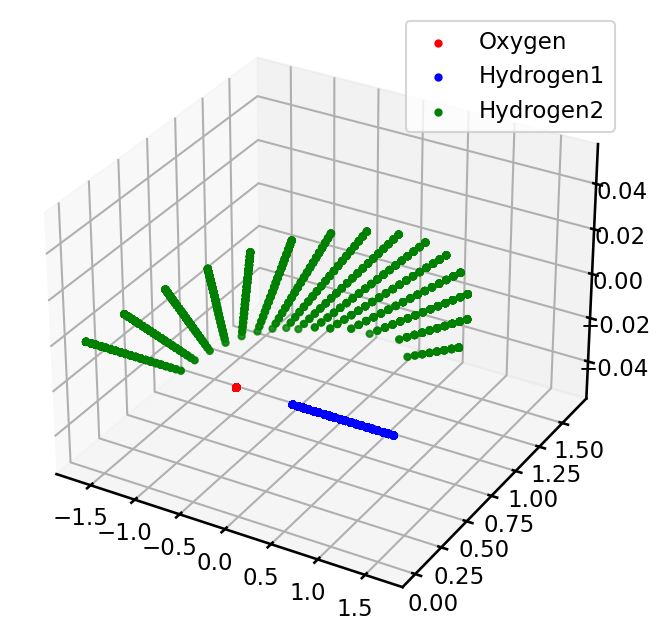

In [8]:
O = []

H1 = []

H2 = []


for a in water_configs:
    p = a.get_positions()
    O.append(p[0])
    H1.append(p[1])
    H2.append(p[2])

coordin = ['x', 'y', 'z']
atoms = ['O', 'H1', 'H2']

for a in atoms:
  exec(f"{a}_x = []")
  exec(f"{a}_y = []")
  exec(f"{a}_z = []")
  atom = globals()[f"{a}"]


  for array in atom:
    globals()[f"{a}_x"].append(array[0])
    globals()[f"{a}_y"].append(array[1])
    globals()[f"{a}_z"].append(array[2])





ax = plt.axes(projection = '3d')
ax.scatter(O_x, O_y, O_z, color = 'red', label = 'Oxygen')
ax.scatter(H1_x, H1_y, H1_z, color = 'blue', label = 'Hydrogen1')
ax.scatter(H2_x, H2_y, H2_z, color = 'green', label = 'Hydrogen2')
ax.legend()



In [9]:
x = [] # input features
y = [] # target values

# Calculating descriptor vectors for each molecule and collect target energies
for a in water_configs:
    p = a.get_positions() # positions: O, H1, H2
    rOH1 = a.get_distance(0, 1)# calculating distance OH1
    rOH2 = a.get_distance(0, 2)# calculating distances OH2
    aHOH = np.dot(p[1]-p[0], p[2]-p[0])# dot product between the vectors OH1 and OH2
    # <Here rOH1 and rOH2 are only distances and aHOH is a dot product of two vectors.>
    x.append([(rOH1 + rOH2), (rOH1 - rOH2)**2, aHOH]) # collect descriptors, they are all scalars.

    y.append(a.get_potential_energy()) # QM energy of a water molecule

We randomly split the data to a train and test set and then use it to train a Gaussian process regression model using `GPy`.

In [10]:
from sklearn.model_selection import train_test_split

# test_size sets the fraction of the test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - 0.2)

X_train = np.array(X_train) # a vector of the 3 descriptors.
y_train = np.array(y_train)[:, None] # GPy needs a 2D array, y_train is a (288, 1) dimensional array of (1,) dimensional arrays

y_train.shape

(577, 1)

The Radial Basis Function (RBF) kernel, also known as the Gaussian kernel, is a popular and widely used kernel function in machine learning and particularly in the context of kernel methods and Gaussian processes. It is used to measure the similarity or distance between data points in a high-dimensional space. The RBF kernel is defined as:

$$ K(x, x') = exp(- {\frac {||x -x'||^2}{2 {σ^2}}})$$

* $K(x, x')$ : This represents the similarity or kernel value between two data points
x and x'.

* $∣∣x−x'∣∣$  : These are vectors representing the data points in a high-dimensional feature space. The RBF kernel measures the similarity between these vectors.

* $σ^2$ : This is a hyperparameter called the `bandwidth` or `lengthscale` parameter. It controls the spread or width of the kernel function. A smaller $σ^2$ results in a narrow kernel with high similarity values for nearby data points, while a larger $σ^2$ results in a wider kernel with similarity values that decay more slowly with distance.

In [11]:
# input_dim: dimensionality of data points - our descriptor vectors have three elements
# variance: range (squared) of the function
print("Range of input data: {:.2f}".format(y_train.max()-y_train.min()))
# lengthscale: characteristic lengthscale - start with a default of 0.5
# ARD: automatic relevance determination - allows separate lengthscales for each three descriptor dimensions

kernel = GPy.kern.Exponential(input_dim=3, variance=1.0, lengthscale=1.0, ARD = True) # ARD : seperate length scale for each input

# the values we chose for the hyperparameters are the initial values.
# they wil be updated during the the optimization.

Range of input data: 18.02


## ARD in the code above ?

Using "automatic relevance determination" (ARD) or separate length scales for each input dimension in Gaussian process regression can be useful in certain cases because it allows the model to capture different degrees of influence or importance of each input dimension on the output. This can lead to more `flexible` and `accurate` models in situations where the relationships between inputs and outputs are not isotropic (i.e., the influence of each dimension varies). we have chosen ARD to be True eventhough we have used the same length scale for all input dimensions. This is because we want the model to be flexible and understand that these three inputs might have different influeneces on the process.

In [12]:
# Generate a Gaussian Process model by adding training data. Start with a small noise parameter.
m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)

# the more we decrease the lengthscale, the more the model captures the details.
# it creates a sort of local sensitivity.

In [13]:
# Optimise the likelihood with respect of the hyperparameters of the model
f_values = m.optimize_restarts(num_restarts = 10);

Optimization restart 1/10, f = 332.1596930800834
Optimization restart 2/10, f = 332.15969309104355
Optimization restart 3/10, f = 332.1596930803203
Optimization restart 4/10, f = 332.1596932012227
Optimization restart 5/10, f = 332.15969365310934
Optimization restart 6/10, f = 332.1596930800752
Optimization restart 7/10, f = 332.15969308341613
Optimization restart 8/10, f = 332.159693092024
Optimization restart 9/10, f = 332.1596930800182
Optimization restart 10/10, f = 332.1596936182646


In [14]:
text = """Optimization restart 1/10, f = 931.0150107775701
Optimization restart 2/10, f = -1061.9613246916674
Optimization restart 3/10, f = -1061.9613511910616
Optimization restart 4/10, f = -1061.961309090385
Optimization restart 5/10, f = -1061.9612657697712
Optimization restart 6/10, f = -1061.9614556363367
Optimization restart 7/10, f = -1061.9613604225588
Optimization restart 8/10, f = -1061.961352808683
Optimization restart 9/10, f = -1061.9612862176673
Optimization restart 10/10, f = -1061.961380119029"""



lines = text.split('\n')

# Initialize lists to store restart numbers and f values
restart_numbers = []
f_values = []

# Parse each line to extract restart number and f value
for line in lines:
    parts = line.split(', ')
    restart_part = parts[0].split(' ')
    restart_number = int(restart_part[2].split('/')[0])
    f_value = float(parts[1].split(' ')[-1])

    restart_numbers.append(restart_number)
    f_values.append(f_value)

# Now, you have the lists restart_numbers and f_values containing the extracted values
Res = []
neg_log_like_opt = []

for i, (restart, f) in enumerate(zip(restart_numbers, f_values)):
    Res.append(restart)
    neg_log_like_opt.append(f)
    print(f"Restart {restart}: f = {f}")

Restart 1: f = 931.0150107775701
Restart 2: f = -1061.9613246916674
Restart 3: f = -1061.9613511910616
Restart 4: f = -1061.961309090385
Restart 5: f = -1061.9612657697712
Restart 6: f = -1061.9614556363367
Restart 7: f = -1061.9613604225588
Restart 8: f = -1061.961352808683
Restart 9: f = -1061.9612862176673
Restart 10: f = -1061.961380119029


In [16]:
restart_color = "\033[94m"
f_color = "\033[92m"
reset_color = "\033[0m"


header = f"{restart_color}Restart     |  {f_color}f Value{reset_color}"
separator = "-------------------------------"


print(header)
print(separator)


for restart, f in zip(Res, neg_log_like_opt):

    row = f"{restart_color}Restart {restart:2d}  |  {f_color}f = {f:.4f}{reset_color}"
    print(row)


print(separator)

Restart     |  f Value
-------------------------------
Restart  1  |  f = 931.0150
Restart  2  |  f = -1061.9613
Restart  3  |  f = -1061.9614
Restart  4  |  f = -1061.9613
Restart  5  |  f = -1061.9613
Restart  6  |  f = -1061.9615
Restart  7  |  f = -1061.9614
Restart  8  |  f = -1061.9614
Restart  9  |  f = -1061.9613
Restart 10  |  f = -1061.9614
-------------------------------


In this code, f represents the optimized value of the objective function (often the negative log likelihood). This value is minimized during the hyperparameter optimization process. The smaller the value of f, the better the model's hyperparameters fit the training data.

In practice, f can be useful for comparing the quality of different hyperparameter configurations or for monitoring the progress of the optimization process. A lower f indicates a better fit to the data. However, the exact interpretation and scaling of f can depend on the specific Gaussian Process library or optimization algorithm you are using.

a "restart" refers to the process of initializing the optimization algorithm multiple times from different initial points. Each of these initial points is randomly chosen or selected according to some predefined strategy.


The motivation behind using multiple restarts is to improve the chances of finding the global optimum or a better local optimum in non-convex optimization problems

In [15]:
# Print the result of the likelihood optimisation
display(m)
m.kern.lengthscale


GP_regression.,value,constraints,priors
Exponential.variance,429.3710072616729,+ve,
Exponential.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.6973657999495845e-245,+ve,


index,GP_regression.Exponential.lengthscale,constraints,priors
[0],180.26697620,+ve,
[1],178.14281251,+ve,
[2],767.33369728,+ve,


`m` contains the trained model: a combination of the _prior_ (in the form of the kernel and its hyperparameters, as well as the noise model) and _data_ (in the form of geometrical descriptors and corresponding energy values).



The noise variance reflects how well the Gaussian process model fits the training data. A lower noise variance indicates that the model fits the data closely, as it implies that the observed data points have less variability around the mean predicted by the GP model.
Conversely, a higher noise variance suggests that there is more variability or uncertainty in the observed data, and the model doesn't fit the data as closely.



In GPR, setting the noise variance too low can lead to overfitting. When the noise variance is underestimated, the model may fit not only the underlying patterns in the data but also the noise itself.
By optimizing the noise variance along with other hyperparameters, we can find a balance that prevents overfitting and provides a more accurate representation of the true underlying process.

In [16]:
from sklearn.metrics import mean_squared_error


# Use the model to predict the energy of water configurations.

y_train_predict, y_train_error = m.predict(np.array(X_train)) # predict energies of training configurations
y_test_predict, y_test_error = m.predict(np.array(X_test))  # predict energies of the test set configurations

# root-mean-square error (RMSE)

mse = mean_squared_error(y_test, y_test_predict[:, 0])
rmse = np.sqrt(mse)


print("RMSE = {:.3f} eV".format(rmse))

RMSE = 0.214 eV



**Plot graphs to show the correlation of actual and predicted energies, and of the actual and predicted error**

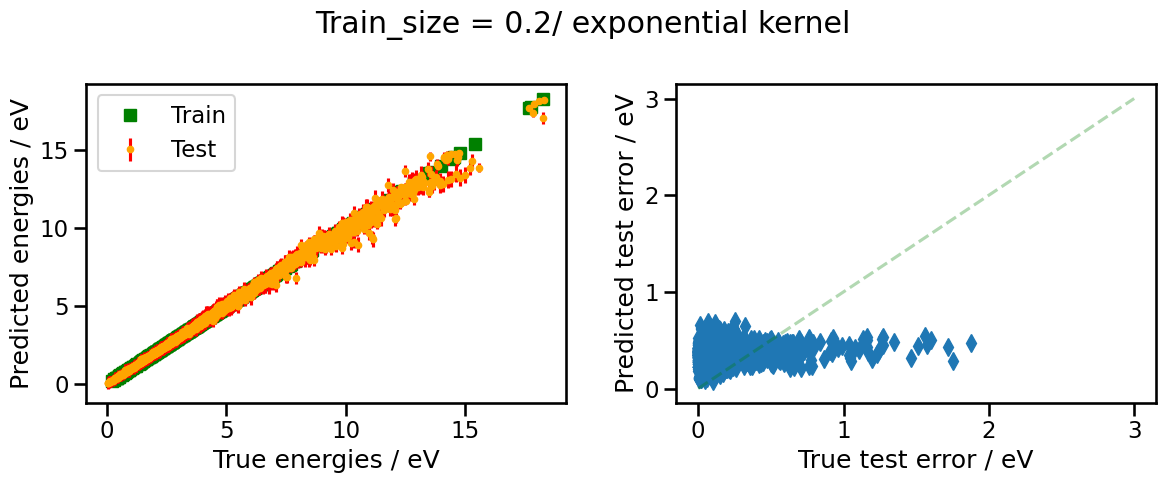

In [17]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot true vs. predicted energies
axs[0].plot(y_train, y_train_predict, "s", label='Train', color = 'green')
axs[0].errorbar(y_test, y_test_predict[:, 0], yerr=np.sqrt(y_test_error[:, 0]), fmt=".", label='Test', color = 'orange', ecolor = 'red')
axs[0].set_xlabel('True energies / eV')
axs[0].set_ylabel('Predicted energies / eV')
axs[0].legend()

# Plot the correlation of actual and predicted error
axs[1].plot(np.abs(y_test - y_test_predict[:, 0]), np.sqrt(y_test_error[:, 0]), "d")
axs[1].set_xlabel('True test error / eV')
axs[1].set_ylabel('Predicted test error / eV')
axs[1].plot(range(4), range(4), "--g", alpha = 0.3)
plt.suptitle('Train_size = 0.2/ exponential kernel')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


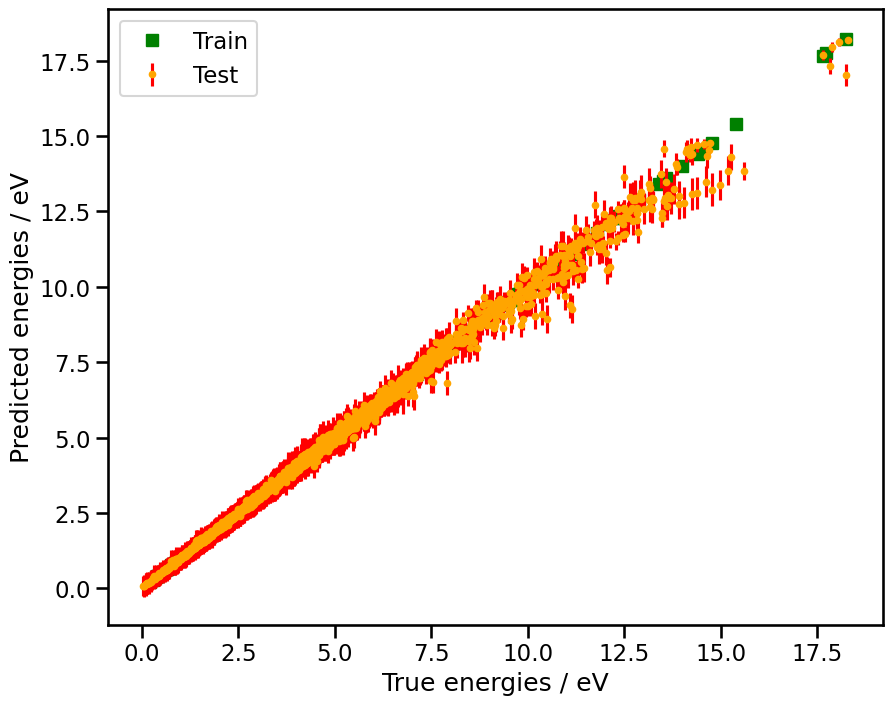

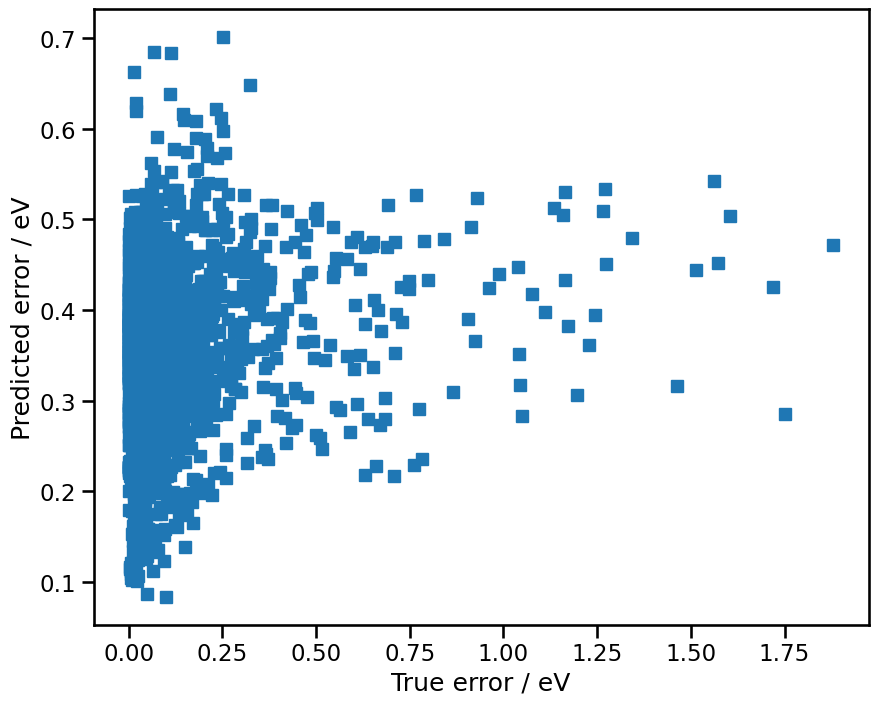

In [18]:
# Plot the correlation of actual and predicted data
plt.plot(y_train,y_train_predict,"s", label='Train', color = 'green')
plt.errorbar(y_test,y_test_predict[:,0],yerr=np.sqrt(y_test_error[:,0]),fmt=".", label='Test', color = 'orange', ecolor = 'red')
plt.xlabel('True energies / eV')
plt.ylabel('Predicted energies / eV')
plt.legend()
plt.show()

# Plot the correlation of actual and predicted error
plt.plot(np.abs(y_test-y_test_predict[:,0]), np.sqrt(y_test_error[:,0]),"s")
plt.xlabel('True error / eV')
plt.ylabel('Predicted error / eV')
plt.show()

In [20]:
#fig, ax = plt.subplots()

#ax.plot(range(len(X_train[0:50])), y_train[:, 0][0:50], color = 'red', label = 'True train label')
#ax.plot(range(len(X_train[0:50])), y_train_predict[:, 0][0:50], color = 'gray', label = 'Predicted train label')
#ax.fill_between(range(len(X_train[0:50])), y_train_predict[:, 0][0:50] - y_train_error[:, 0][0:50], y_train_predict[:, 0][0:50] + y_train_error[:, 0][0:50], color= 'magenta',
#                alpha = 0.3, label = 'prediction error')

#ax.grid()
#ax.legend()
#ax.set_xlabel('water configuration indeces')
#ax.set_ylabel('energy (eV)')
#plt.show()

In [21]:
len(X_train)

577

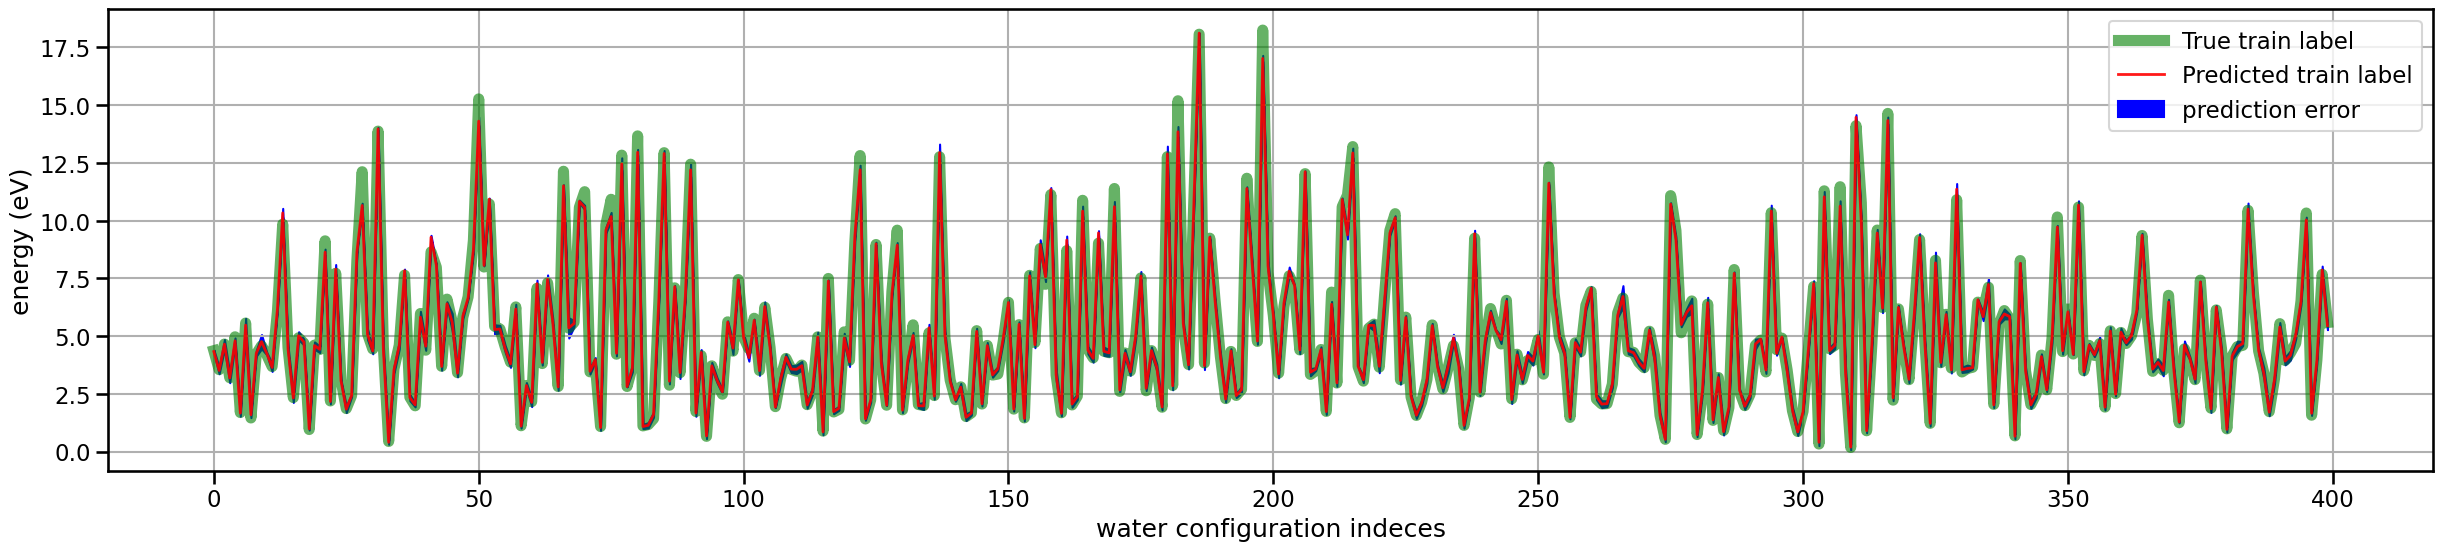

In [22]:
# number of test input is 2598
# number of train data is


fig, ax = plt.subplots(1, 1, figsize = (30, 6))

ax.plot(range(len(X_test[0:400])), y_test[0:400], color = 'green', label = 'True train label', alpha = 0.6, linewidth = 8)
ax.plot(range(len(X_test[0:400])), y_test_predict[:, 0][0:400], color = 'red', label = 'Predicted train label', alpha = 0.9, linewidth = 2)
ax.fill_between(range(len(X_test[0:400])), y_test_predict[:, 0][0:400] - y_test_error[:, 0][0:400], y_test_predict[:, 0][0:400] + y_test_error[:, 0][0:400], color= 'blue',
                alpha = 1, label = 'prediction error')

ax.grid()
ax.legend()
ax.set_xlabel('water configuration indeces')
ax.set_ylabel('energy (eV)')
plt.show()

the model was pretty accurate, although we have used the 10% of the data for the training. definitely we will need more data.

We only used 10% of the data for training. By adapting the code above, starting from where we split the data into test and train set, fit further GP models with different fractions (10%, 20%, 40%, 80%) of training data - don't forget to optimise the likelihood. Summarise in a table how the root mean squared error (RMSE) changes. Write a short paragraph about the advantages and disadvantages of using more training data.

In [23]:
import pandas as pd

df = pd.DataFrame(columns=['train_size', 'RMSE'])

df['train_size'] = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]

for i, train_size in enumerate(df.train_size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_size)
    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]
    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)
    y_test_predict, y_test_error = m.predict(np.array(X_test))
    rmse = np.sqrt(np.mean((np.array(y_test)-y_test_predict[:,0])**2))
    #print(train_size, rmse)
    df.iloc[i, 1] = rmse

df

 /opt/anaconda3/envs/work/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 273.10024832813633
Optimization restart 2/5, f = 273.100248332427
Optimization restart 3/5, f = 273.1002486220164
Optimization restart 4/5, f = 273.1002483339769
Optimization restart 5/5, f = 273.1002483425028
Optimization restart 1/5, f = 373.8338803163143
Optimization restart 2/5, f = 373.8338788600427
Optimization restart 3/5, f = 373.8338790157537
Optimization restart 4/5, f = 373.8338788762163
Optimization restart 5/5, f = 373.8338788560392
Optimization restart 1/5, f = 253.82536741907484
Optimization restart 2/5, f = 253.825367412712
Optimization restart 3/5, f = 253.82536740672504
Optimization restart 4/5, f = 253.82536746331994
Optimization restart 5/5, f = 253.82536741087915
Optimization restart 1/5, f = 90.33901399654064
Optimization restart 2/5, f = 90.33901702865433
Optimization restart 3/5, f = 90.33901398865169
Optimization restart 4/5, f = 90.33901399393903
Optimization restart 5/5, f = 90.33901413638978
Optimization restart 1/5, f = -328.10

,train_size,RMSE
0,0.10,0.392647
1,0.20,0.203495
2,0.40,0.111711
3,0.50,0.114576
4,0.70,0.117625
5,0.80,0.079073
6,0.95,0.071751


In [24]:
df.to_csv('./train_size.csv')

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import GPy
from sklearn.metrics import mean_squared_error

data_sizes = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]

results_list = []

for data_size in data_sizes:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - data_size, random_state=42)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]
    
    kernel = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=10., ARD=True)
    
    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)
    
    optimized_noise_variance = m.Gaussian_noise.variance[0]
    optimized_kernel_variance = m.kern.variance[0]
    optimized_lengthscale = m.kern.lengthscale[0]
    y_pred, _ = m.predict(np.array(X_test))
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_list.append({
        'Data Size': data_size,
        'Optimized Noise Variance': optimized_noise_variance,
        'Optimized Kernel Variance': optimized_kernel_variance,
        'Optimized Lengthscale': optimized_lengthscale,
        'RMSE': rmse
    })

results_df = pd.DataFrame(results_list)

# Find the best configuration based on some criterion (e.g., lowest RMSE)
best_config = results_df.loc[results_df['RMSE'].idxmin()]

# Print the best configuration
print("Best Configuration:")
print(best_config)

# Optionally, save the results to a CSV file
results_df.to_csv('optimized_results.csv', index=False)


Optimization restart 1/5, f = -288.54893125542
Optimization restart 2/5, f = -288.5489423135718
Optimization restart 3/5, f = -288.54895873007223
Optimization restart 4/5, f = -288.54894364573494
Optimization restart 5/5, f = -288.548932749524
Optimization restart 1/5, f = 826.1629687656889
Optimization restart 2/5, f = -1130.95075124441
Optimization restart 3/5, f = -1130.950858093692
Optimization restart 4/5, f = -1130.9508910344164
Optimization restart 5/5, f = -1130.950838374003
Optimization restart 1/5, f = 2703.370568907181
Optimization restart 2/5, f = -3741.3615550039103
Optimization restart 3/5, f = -3741.6398562521044
Optimization restart 4/5, f = -3741.5331230318434
Optimization restart 5/5, f = -3741.267469686679
Optimization restart 1/5, f = 1488.291428582666
Optimization restart 2/5, f = -5582.449204006391
Optimization restart 3/5, f = -5582.86031370865
Optimization restart 4/5, f = -5582.827365590185
Optimization restart 5/5, f = -5581.216667431496
Optimization restart 1

In [30]:
#results_df = results_df.drop(columns ='Optimized Period')
results_df

,Data Size,Optimized Noise Variance,Optimized Kernel Variance,Optimized Lengthscale,RMSE
0,0.10,3.090808e-04,66971.268313,0.899479,0.052409
1,0.20,6.778878e-05,53736.388597,0.754923,0.031690
2,0.40,6.669537e-21,17613.256843,0.422043,0.106799
3,0.50,5.562685e-309,19040.550996,0.403651,0.061331
4,0.70,5.562685e-309,26836.476127,0.370537,0.038405
5,0.80,5.562685e-309,26355.362193,0.370101,0.045042
6,0.95,5.562685e-309,21702.320565,0.368144,0.000259


### Optimising the geometry of the water molecule, using a Gaussian Process energy model
In the following section, we will relax the Cartesian coordinates of a water molecule, in order to find the equilibrium geometry. We will use a wrapper function that generates the symmetrised descriptors and using the GP model, predicts the energy of the water molecule. For simplicity, we use the Nelder-Mead algorithm to find the minimum of the function, as it does not require access to the gradients.

In [31]:
# This is the wrapper function: Cartesian coordinates -> symmetrised descriptors -> GP
def GP_water_energy(x):
    _x = np.reshape(x, (3,3)) # Input is a flat array of x,y,z coordinates of three atoms.
    r1 = np.linalg.norm(_x[0] - _x[1]) # rOH1
    r2 = np.linalg.norm(_x[0] - _x[2]) # rOH2
    a = np.dot(_x[0] - _x[1],
               _x[0] - _x[2]) # dot product of the two OH vectors
    _xx = np.array([[(r1 + r2),
                     (r1 - r2)**2,
                     a]]) # symmetrised descriptor (see above)
    res = m.predict(_xx)[0][0][0] # GP prediction
    return res

We start from a not-too crazy initial condition, and relax the position of all atoms.

In [32]:
from scipy.optimize import minimize

x0 = np.array([0,0,0,       # Oxygen atom
               1.2,0,0,     # 1st hydrogen atom
               -0.5,0.7,0]) # 2nd hydrogen atom

res = minimize(GP_water_energy, # function to minimise
               x0,              # initial condition
               method='nelder-mead',
               options={"maxiter":1000, # number of iterations in the minimiser
                        "fatol":1e-6    # stopping criterion (tolerance)
                       })
# res.x contains the final configuration

In [33]:
res


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.001169881139558339
             x: [-1.698e-04  3.283e-04 -3.840e-03  9.563e-01  6.596e-04
                  3.496e-03 -2.648e-01  9.194e-01  1.350e-03]
           nit: 402
          nfev: 959
 final_simplex: (array([[-1.698e-04,  3.283e-04, ...,  9.194e-01,
                         1.350e-03],
                       [-1.698e-04,  3.283e-04, ...,  9.194e-01,
                         1.350e-03],
                       ...,
                       [-1.698e-04,  3.283e-04, ...,  9.194e-01,
                         1.350e-03],
                       [-1.698e-04,  3.283e-04, ...,  9.194e-01,
                         1.350e-03]]), array([-1.170e-03, -1.170e-03, -1.170e-03, -1.170e-03,
                       -1.170e-03, -1.170e-03, -1.170e-03, -1.169e-03,
                       -1.169e-03, -1.169e-03]))

In [34]:
# We transform the Cartesian coordinates into bond lengths and the bond angle,
# for easier interpretation


_x = np.reshape(res.x, (3, 3))
r1 = np.linalg.norm(_x[0] - _x[1])
r2 = np.linalg.norm(_x[0] - _x[2])
a = np.dot(_x[0] - _x[1],_x[0] -_x[2])
print("r1 = {:.3f} A\nr2 = {:.3f} A\nangle = {:.1f} degrees".format(r1,r2,np.rad2deg(np.arccos(a))))

r1 = 0.957 A
r2 = 0.956 A
angle = 104.6 degrees


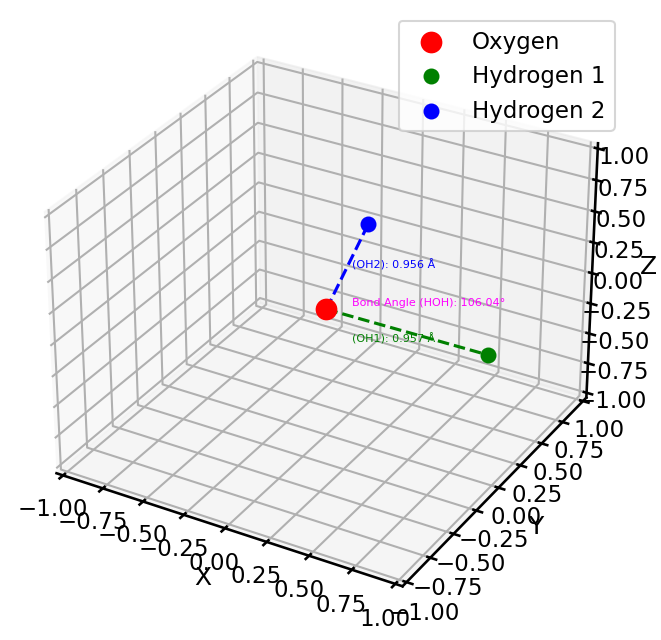

In [36]:
import plotly.graph_objects as go
import webbrowser



fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

oxygen = _x[0]
hydrogen1 = _x[1]
hydrogen2 = _x[2]

bond_length_oh1 = r1
bond_length_oh2 = r2

cos_theta = a/ (bond_length_oh1 * bond_length_oh2)
bond_angle = np.arccos(cos_theta) * (180.0 / np.pi)


ax.scatter(*oxygen, c = 'r', s = 200, label = 'Oxygen')
ax.scatter(*hydrogen1, c = 'g', s = 100, label = 'Hydrogen 1' )
ax.scatter(*hydrogen2, c = 'b', s = 100, label = 'Hydrogen 2')


# the bonds:
ax.plot([oxygen[0], hydrogen1[0]], [oxygen[1], hydrogen1[1]], [oxygen[2], hydrogen1[2]], 'g--')
ax.plot([oxygen[0], hydrogen2[0]], [oxygen[1], hydrogen2[1]], [oxygen[2], hydrogen2[2]], 'b--')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.text(0.1, 0.1, -0.3, f'(OH1): {bond_length_oh1:.3f} Å', fontsize=8, color = 'g')
ax.text(0.1, 0.1, 0.3, f'(OH2): {bond_length_oh2:.3f} Å', fontsize=8, color = 'b')
ax.text(0.1, 0.1, 0.0, f'Bond Angle (HOH): {bond_angle:.2f}°', fontsize=8, color = 'magenta')


ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)


ax.legend()


plt.show()





based on the measurement conducted by G Császár et al, The mass-independent [Born-Oppenheimer (BO)] equilibrium bond length and bond angle on the ground electronic state PES of water is r(e) (BO)=0.957 82 A and theta e (BO)=104.48(5) degrees , respectively. The bond_lengths estimations are very percise; however, the theta estimation sufferes from inaccuracy.

## different kernels:
Try different kernels `GPy.kern.` in the Gaussian Process regression.

In [1]:
# grid search for the training data sizes.


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import GPy


data_sizes = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]


results_df = pd.DataFrame(columns=['Data Size', 'Optimized Noise Variance', 'Optimized Kernel Variance', 'Optimized Period'])

for data_size in data_sizes:

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=data_size, random_state=42)

    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]


    kernel = GPy.kern.Exponential(input_dim=3, variance=1.0, lengthscale=1.0)


    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)


    optimized_noise_variance = m.Gaussian_noise.variance[0]
    optimized_kernel_variance = m.kern.variance[0]
    optimized_period = m.kern.lengthscale[0]
    y_pred, _ = m.predict(np.array(X_test))


    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    results_df = results_df.append({'Data Size': data_size,
                                    'Optimized Noise Variance': optimized_noise_variance,
                                    'Optimized Kernel Variance': optimized_kernel_variance,
                                    'Optimized Lengthscale': optimized_period,
                                    'RMSE': rmse},
                                    ignore_index=True)



# Find the best configuration based on some criterion (e.g., lowest error)
best_config = results_df.loc[results_df['Optimized Noise Variance'].idxmin()]

# Print the best configuration
print("Best Configuration:")
print(best_config)

# Optionally, save the results to a CSV file
results_df.to_csv('optimized_results_EXP.csv', index=False)

NameError: name 'x' is not defined

In [ ]:
results_df.drop(columns = 'Optimized Period')
results_df

,Data Size,Optimized Noise Variance,Optimized Kernel Variance,Optimized Period,Optimized Lengthscale,RMSE
0,0.10,3.966275e-150,543.941475,NaN,581.958201,0.080987
1,0.20,1.347171e-192,535.943885,NaN,522.131189,0.100682
2,0.40,1.936839e-46,508.252833,NaN,397.502857,0.127803
3,0.50,1.290222e-90,498.420791,NaN,335.854374,0.141563
4,0.70,2.243710e-108,458.685878,NaN,209.125833,0.214021
5,0.80,3.734601e-137,394.782523,NaN,150.657129,0.356509
6,0.95,6.869132e-58,202.123022,NaN,36.719272,0.807312
